# Top 7 Multiclass Metrics Explained Neatly
## TODO
![](images/pexels.jpg)
<figcaption style="text-align: center;">
    <strong>
        Photo by 
        <a href='https://www.pexels.com/@deon-black-3867281?utm_content=attributionCopyText&utm_medium=referral&utm_source=pexels'>Deon Black</a>
        on 
        <a href='https://www.pexels.com/photo/long-fitness-health-measure-5915361/?utm_content=attributionCopyText&utm_medium=referral&utm_source=pexels'>Pexels</a>
    </strong>
</figcaption>

### Setup

In [102]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import rcParams

rcParams["figure.figsize"] = [12, 9]
rcParams["figure.autolayout"] = True
rcParams["xtick.labelsize"] = 15
rcParams["ytick.labelsize"] = 15
rcParams["font.size"] = 15
rcParams["legend.fontsize"] = "small"

warnings.filterwarnings("ignore")

In [40]:
### HIDE

from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    cohen_kappa_score,
    confusion_matrix,
    f1_score,
    log_loss,
    matthews_corrcoef,
    plot_confusion_matrix,
    precision_score,
    recall_score,
    roc_auc_score,
)
from sklearn.model_selection import train_test_split

labels = ["Ideal", "Premium", "Good", "Fair"]

# Generate dataset
X, y = make_classification(
    n_samples=1000,
    n_features=10,
    n_redundant=3,
    n_informative=7,
    n_classes=4,
    random_state=1121218,
    weights=[0.2, 0.2, 0.3, 0.3],
)

# Train/test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

# Init logreg
logreg = LogisticRegression()
# Fit
_ = logreg.fit(X_train, y_train)
# Label predict
y_pred = logreg.predict(X_test)
# Predict proba
y_preb_probs = logreg.predict_proba(X_test)

cm = confusion_matrix(y_test, y_pred)

### Introduction

I have recently published [my most challenging article](https://towardsdatascience.com/comprehensive-guide-to-multiclass-classification-with-sklearn-127cc500f362?source=your_stories_page-------------------------------------) which was on the topic of multiclass classification (MC). The difficulties I have faced along the way were largely due to the excessive number of classification metrics that I had to learn and explain. By the time I finished, I realized that these metrics deserved an article of their own. 

So, this post will be about the 6 most commonly used MC metrics: precision, recall, F1 score, ROC AUC score, Cohen Kappa score, Matthew's correlation coefficient and log loss. You will learn how they are calculated, their nuances in Sklearn and how to use them in your own workflow.

### Interpreting an N by N confusion matrix

All of the metrics you will be introduced today are associated with confusion matrices in one way or the other. While a 2 by 2 confusion matrix is intuitive and easy to understand, larger confusion matrices can be *truly confusing*. For this reason, it is a good idea to get some exposure to larger, N by N matrices before diving deep into the metrics that are derived from them. 

Throughout this article, we will use the example of diamond classification. Specifically, the target contains 4 types of diamonds: ideal, premium, good, and fair. Evaluating any type of classifier on this diamonds data will produce a 4 by 4 matrix:

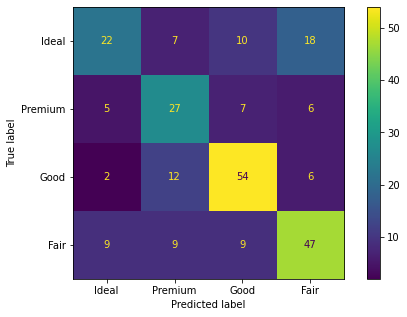

In [41]:
## HIDE
fig, ax = plt.subplots(figsize=(8, 5))

cmp = ConfusionMatrixDisplay(cm, display_labels=labels)
cmp.plot(ax=ax);

Even though it gets more difficult to interpret the matrix as the number of classes increases, there are sure-fire ways to find your way around any matrix of any shape. 

The first step is always identifying your positive and negative classes. This depends on the problem you are trying to solve. If the classification is balanced, i. e. you care about each class equally (which is rarely the case), there may not be any positive or negative classes. If this is the case, positive and negative classes are defined per-class basis.

However, as a jewelry store owner, you may want your classifier to be better at classifying ideal and premium diamonds better because they are more expensive. In that case, ideal and premium labels will be the positive class and the other labels are collectively considered as negative. 

After identifying the positive and negative classes, define what true positives, true negatives, false positives, false negatives are. In the above diamonds case:

- **True positives, type 1**: actual ideal, predicted ideal
- **True positives, type 2**: actual premium, predicted premium
- **True negatives**: any negative class labels (good, fair) predicted correctly
- **False positives**: actual value belongs to good or fair class but predicted as either ideal or premium
- **False negative**: actual value belongs to the positive classes but predicted as either good or fair

Once you define them, finding each from the matrix should be easy as it is only the matter of simple sums and subtractions.

### From binary metrics to multiclass

The majority of classification metrics are defined for binary cases by default. In extending these binary metrics to multiclass, several averaging techniques are used. 

First, a multiclass problem is broken down into a series of binary problems using either One-vs-One (OVO) or One-vs-Rest (OVR, also called One-vs-All) approaches. OVO presents computational drawbacks, so, professionals prefer OVR approach. As I discussed the differences between these two approaches at length in [my last article](https://towardsdatascience.com/comprehensive-guide-to-multiclass-classification-with-sklearn-127cc500f362), we will only focus on OVR today. 

Essentially, One-vs-Rest strategy converts a multiclass problem into a series of binary tasks for each class in the target. For example, classifying 4 types of diamond types can be binarized into 4 tasks with OVR:

- Task 1: ideal vs. \[premium, good, fair\] - i.e., ideal vs. not ideal
- Task 2: premium vs. \[ideal, good, fair\] - i.e., premium vs. not premium
- Task 3: good vs. \[ideal, premium, fair\] - i.e., good vs. not good
- Task 4: fair vs. \[ideal, premium, good\] - i.e., fair vs. not fair

For each task, one binary classifier will be built (should be the same classifier across all tasks) and their performance is measured using a binary classification metric like precision (or any of the metrics we will discuss today). The result will be 4 precision scores. To compare one classifier to another, we need 1 precision score not 4, so we need a way to represent precision across all classes. This is where the averaging techniques comes in. 

Specifically, there are 3 averaging techniques applicable to multiclass classification:

- **macro**: this is a simple arithmetic mean of all metrics across classes. This technique gives equal weights to all classes making it a good option for balanced classification tasks. 
- **weighted**: accounts for class imbalance by computing the average of binary metrics weighted by the number of samples of each class in the target. If 3 (*precision scores*) for 3 classes are: class 1 (0.85), class 2 (0.80) and class 3 (0.89), the weighted average will be calculated by multiplying each score to the number of occurrences of each class and dividing by the total number of samples.
- **micro**: this is the same as accuracy. Micro-averaging is found by diving the sum of the diagonal cells of the matrix by the sum of the non-diagonal cells - i.e., accuracy. As accuracy is such a misleading metric, this averaging technique is almost never used.

Let's finally move on to the actual metrics now!

### Precision and recall for multiclass classification

Precision answers the question of "what proportion of **predicted positives** are truly *positive*?" Of course, you can only answer this question in binary classification. That's why you ask the question as many times as the number of classes in the target. Each time, you will be asking the question for one class against others. For our diamonds classification, one example is "what proportion of predicted ideal diamonds are actually ideal?" 

The precision is calculated by dividing the true positives by the sum of true positives and false positives (*triple-p rule*):
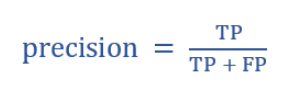

Let's calculate precision for the ideal class. Here is the confusion matrix for reference:

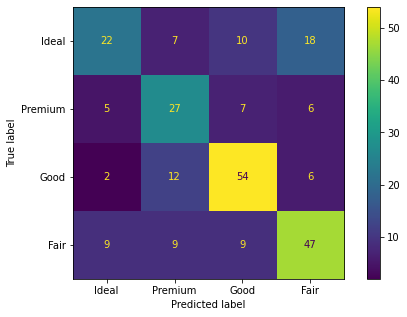

In [42]:
## HIDE
fig, ax = plt.subplots(figsize=(8, 5))

cmp = ConfusionMatrixDisplay(cm, display_labels=labels)
cmp.plot(ax=ax);

True positives for the ideal diamonds is the top left cell (22). False positives are all the cells where other types of diamonds are predicted as ideal. These are the cells below the top left cell (5 + 2 + 9 = 19). So, precision will be:

**Precision (ideal): 22 / (22 + 19) =  0.536** - a terrible score.

You should optimize your model for precision when you want to decrease the number of *false positives*. In our case, it would make sense to optimize for the precision of ideal diamonds. The reason is that ideal diamonds are the most expensive and getting a false positive means classifying a cheaper diamond as ideal. If you accidentally slip such an occurrence, you might get sued for fraud. Now, let's move on to *recall*.

Recall answers the question of "what proportion of **actual positives** are correctly classified?" It is calculated by dividing the number of true positives by the sum of true positives and false negatives.

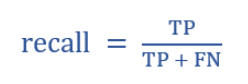

Let's calculate it for the premium class diamonds.

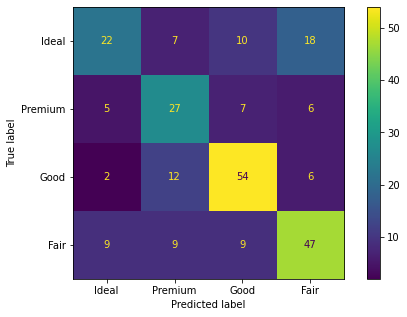

In [43]:
## HIDE
fig, ax = plt.subplots(figsize=(8, 5))

cmp = ConfusionMatrixDisplay(cm, display_labels=labels)
cmp.plot(ax=ax);

There are 27 true positives  (2nd row, 2nd column). False negatives would be any occurrences where premium diamonds were classified as either ideal, good or fair. These would be the cells to the left and right of the true positives cell (5 + 7 + 6 = 18). So, recall will be:

**Recall (premium): 27 / (27 + 18) = 0.6** - not a good score either.

You should optimize your model for recall if you want to decrease the number of *false negatives*. If you are trying to detect blue bananas among yellow and red ones, you would want to decrease false negatives because blue bananas are very rare (so rare that you are hearing about them for the first time). You don't want to mix them with common bananas.

If you want to see precision and recall for all classes and their macro and weighted averages, you can use Sklearn's `classification_report` function. Assuming that our labels are in `y_test` and predictions are in `y_pred`, the report for the diamonds classification will be:

In [48]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred, target_names=labels))

              precision    recall  f1-score   support

       Ideal       0.58      0.39      0.46        57
     Premium       0.49      0.60      0.54        45
        Good       0.68      0.73      0.70        74
        Fair       0.61      0.64      0.62        74

    accuracy                           0.60       250
   macro avg       0.59      0.59      0.58       250
weighted avg       0.60      0.60      0.59       250



The last two rows show macro and weighted averages of precision and recall and they don't look too good!

### F1 score for multiclass classification

Due to their nature, precision and recall are in a trade-off relationship. You many have to optimize one at the cost of the other. However, what if you wanted a classifier that is equally good at minimizing both the false positives and false negatives? For example, it would make sense to have a model that is equally good at catching cases where you are accidentally selling cheap diamonds as ideal so that you won't get sued and detecting occurrences where you are accidentally selling ideal diamonds for a cheaper price. 

This is where the F1 score comes in. It is calculated by taking the harmonic mean of precision and recall and ranges from 0 to 1.

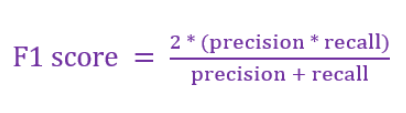

Why take the harmonic mean rather than a simple arithmetic mean? Well, harmonic mean has a nice arithmetic property representing a truly balanced mean. If either precision or recall is low, it suffers significantly. For example, let's say we are comparing two classifiers to each other. The first classifiers precision and recall is 0.9, 0.9 and the second ones precision and recall is 1.0 and 0.7. Calculating the F1 for both gives us 0.9 and 0.82. As you can see, the low recall score of the second classifier weighed the score down.

Both of the averaged F1 scores can be seen using the classification report output:

In [50]:
print(classification_report(y_test, y_pred, target_names=labels))

              precision    recall  f1-score   support

       Ideal       0.58      0.39      0.46        57
     Premium       0.49      0.60      0.54        45
        Good       0.68      0.73      0.70        74
        Fair       0.61      0.64      0.62        74

    accuracy                           0.60       250
   macro avg       0.59      0.59      0.58       250
weighted avg       0.60      0.60      0.59       250



F1 score will usually be between precision and recall but taking a weighted average may give a value outside their range.

Stick around for to the next couple sections where we will discuss ROC AUC score and compare it to F1. You will find out the major drawback of both of the metrics.

### ROC AUC score for multiclass classification

Another commonly used metric in binary classification is the Area Under the Receiver Operating Characteristic Curve (ROC AUC or AUROC). It quantifies the model's ability to distinguish between each class. The metric is only used with classifiers that can generate class membership probabilities on in terms of Sklearn estimators, has a `predict_proba()` method.

For example, if the target contains cats and dogs class, then, a classifier with `predict_proba` method may generate membership probabilities such as 0.35 for a cat and 0.65 for a dog for each sample. Then, each prediction is classified based on a decision threshold like 0.5. Before explaining AUROC further, let's see how it is calculated for MC in detail.

After a binary classifier with `predict_proba` method is chosen, it is used to generate membership probabilities for the first binary task in OVR. Then, an initial, close to 0 decision threshold is chosen. Using the threshold, predictions are made and a confusion matrix is created. From this confusion matrix, two metrics, True Positive rate (same as recall) and False positive rate are calculated:

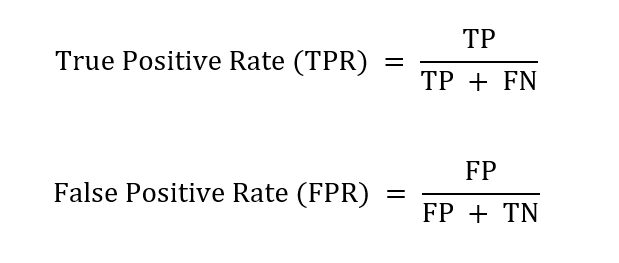

Then, a new, higher threshold is chosen and a new confusion matrix is created. Using this confusion matrix, new TPR and FPR are calculated. This process is repeated for many different decision thresholds between 0 and 1 and for each threshold, new TPR and FPR are found. At the end, all TPR and FPRs are plotted against each other:

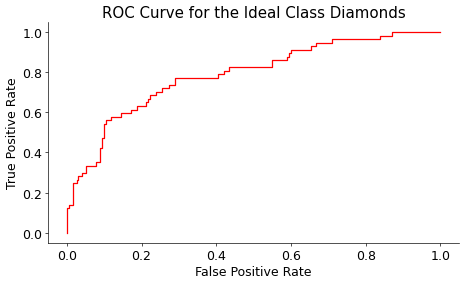

In [98]:
from sklearn.metrics import roc_curve

plt.figure(figsize=(8, 5))
fpr, tpr, _ = roc_curve(y_test == 0, y_preb_probs[:, 0])

plt.plot(fpr, tpr, color="red")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for the Ideal Class Diamonds");

The plot is the implementation of calculating of ROC curve of Ideal class vs. other classes in our diamonds dataset. This whole process is repeated for all other binary tasks. In other words, 3 more ROC curves are found:

In [99]:
from sklearn.metrics import auc

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(y_test == i, y_preb_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

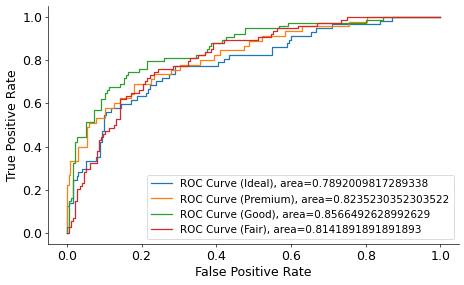

In [103]:
plt.figure(figsize=(8, 5))

for i in range(4):
    plt.plot(fpr[i], tpr[i], label=f"ROC Curve ({labels[i]}), area={roc_auc[i]}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")

plt.legend()
plt.show()

The final plot also shows the area under these curves. The larger the AUROC is, the greater the distinction between the classes. The final AUROC is also averaged using either macro or weighted methods. Here is the implementation of all this in Sklearn:

```python
from sklearn.metrics import roc_auc_score

# Generate class membership probabilities
y_preb_probs = clf.predict_proba(X_test)
```

In [105]:
roc_auc_score(y_test, y_preb_probs, average="weighted", multi_class="ovr")

0.8227401519938421

We got an average AUROC score of 0.82.